# Поиск оптимального портфеля из двух акций
Задача поиска оптимального портфеля из акций Apple и Google при помощи критериев:
* Value at Risk
* Conditional Value at Risk
* $\mu-\sigma$ оптимизация

## Подключение библиотек

In [1]:
!pip install yfinance

In [ ]:
import typing as tp

import numpy as np
import cvxpy as cp
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt

## Расчет выборочных статистик и построение графиков распределения

In [3]:
tickers = ['AAPL', 'GOOG']
first, second = tickers

step = 0.001
alpha = 0.95
min_return = 1.0012

start_date = '2017-01-01'
end_date = '2018-05-25'

In [4]:
def read_stock_data(tickers: list[str],
                    start_date: str,
                    end_date: str | None = None
                    ) -> np.ndarray:
    """
    Get ticker data from Yahoo Finance API
    """
    data = yf.download(tickers, start_date, end_date)
    close_prices = data['Adj Close']
    returns = (close_prices.shift(-1) / close_prices)[:-1]
    return returns

In [5]:
def plot_stock(data: np.ndarray, ticker: str) -> None:
    """
    Plot sample return distribution histograms for ticker
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    plt.suptitle(f'{ticker} returns distribution')

    sns.ecdfplot(data, ax=ax[0], label='CDF', linewidth=2)
    ax[0].legend()
    ax[0].set_ylabel('CDF')
    ax[0].set_xlabel(f'{ticker} returns')

    sns.histplot(data, stat='density', ax=ax[1], label='PDF', color='red', bins=50)
    ax[1].legend()
    ax[1].set_ylabel('PDF')
    ax[1].set_xlabel(f'{ticker} returns')

    plt.show()


def plot_tickers(data: np.ndarray, tickers: list[str]) -> None:
    """
    Plot sample return distribution histograms for list of tickers from dataset
    """
    for tick in tickers:
        x = data[tick].to_numpy()
        plot_stock(x, tick)


def calculate_statistics(data: np.ndarray, tickers: list[str]):
    """
    Calculate sample statistics from ticker dataset
    """
    first, second = tickers
    means = data.mean()
    variances = data.var()
    correlation = data.corr()[first][second]
    covariance = data.cov().to_numpy()
    return means, variances, correlation, covariance

In [6]:
data = read_stock_data(tickers, start_date, end_date)

[*********************100%%**********************]  2 of 2 completed


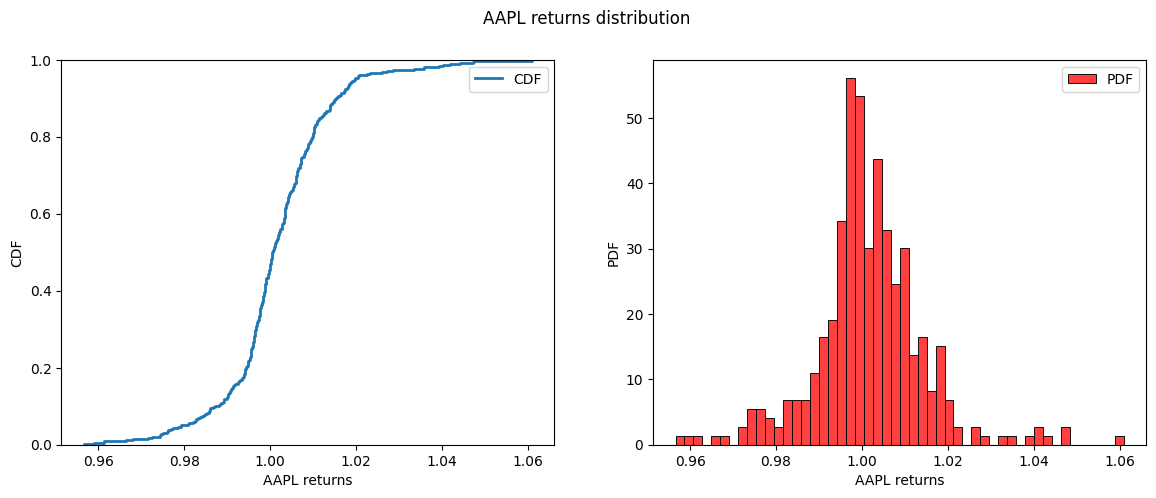

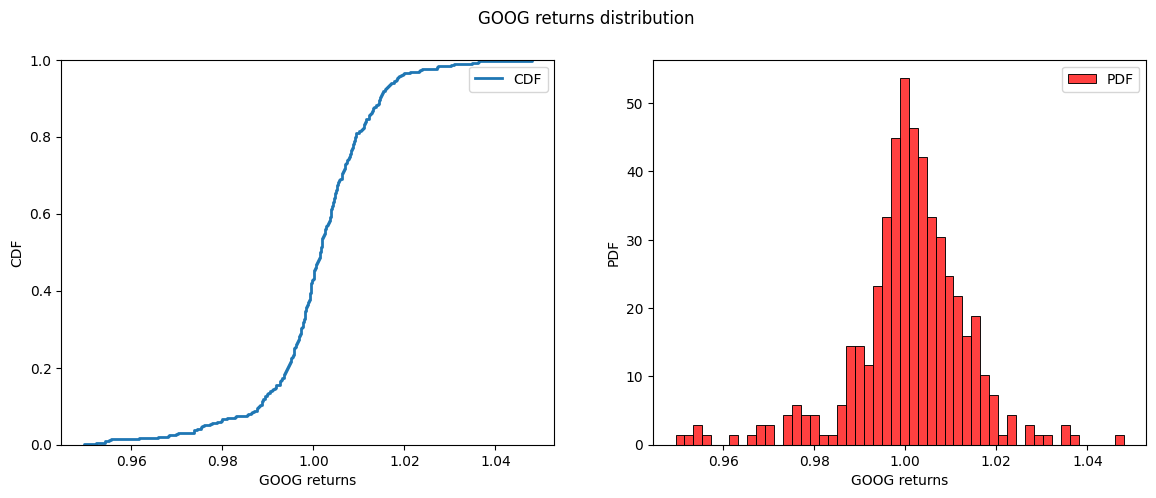

In [7]:
plot_tickers(data, tickers)

In [8]:
expected_returns, sigmas, corr, covariance = calculate_statistics(data, tickers)

for m, s, tick in zip(expected_returns, sigmas, tickers):
    print(f'{tick}')
    print(f'Expected return: {m:.6f}')
    print(f'Variance of return: {s:.6f}\n')
print(f'Correlation coefficient: {corr:.6f}')

AAPL
Expected return: 1.001530
Variance of return: 0.000166

GOOG
Expected return: 1.000987
Variance of return: 0.000161

Correlation coefficient: 0.579208


## Оптимальный портфель (наивный перебор)

### Алгоритм расчета $VaR$

$VaR_{\alpha}(X) = q_{1-\alpha}$ - квантиль распределения.

Для расчета по выборке используется `np.quantile(x, 1 - alpha)`, который возвращает `q * (n - 1) + 1` элемент массива, в данном случае это `18.45` - между 18 и 19 элементами массива.

### Алгоритм расчета $CVaR$

$CVaR_{\alpha}(X) = \mathbb{E}[X | X < VaR_{\alpha}(X)]$ - среднее значение при условии того, что величина меньше $VaR_{\alpha}$.

Для расчета по выборке используется `np.mean` по части выборки, которая меньше рассчитанного $VaR_{\alpha}$

In [9]:
def variance_at_risk(data: np.ndarray, alpha=0.95):
    """
    Calculate Value at Risk for sample
    """
    return np.quantile(data, 1 - alpha)


def expected_shortfall(data: np.ndarray, alpha=0.95):
    """
    Calculate Expected Shortfall a.k.a. Conditional Value at Risk for sample
    """
    var = variance_at_risk(data, alpha)
    return data[data < var].mean()

In [10]:
for tick in tickers:
    x = data[tick].to_numpy()
    print(f'{tick}, alpha = {alpha}')
    print(f'Value at Risk: {variance_at_risk(x, alpha):.6f}')
    print(f'Conditional Value at Risk: {expected_shortfall(x, alpha):.6f}\n')

AAPL, alpha = 0.95
Value at Risk: 0.979976
Conditional Value at Risk: 0.972099

GOOG, alpha = 0.95
Value at Risk: 0.976550
Conditional Value at Risk: 0.966386



### Алгоритм перебора портфелей
С фиксированным шагом перебираем все портфели вида `(x, 1 - x)` для двух акций и берем тот, в котором значение критерия максимально.

In [11]:
def optimize_by_step(f: tp.Callable[[float], float],
                     step: float,
                     start: float = 0,
                     end: float = 1,
                     maximize=True
                     ):
    """
    Find optimal solution for scalar function within 1-D grid using bruteforce
    """
    best = start
    best_value = None
    for x in np.arange(start, end + step, step):
        if best_value is None or f(x) > best_value:
            best_value = f(x)
            best = x
    return best

### Оптимальный по Value at Risk портфель

In [12]:
x = optimize_by_step(
    lambda x: variance_at_risk(data[first] * x + data[second] * (1 - x), alpha),
    step=0.0005
)

w = np.array([x, 1-x])

var_portfolio = {
    'coef': w,
    'mu': w @ expected_returns,
    'variance': w @ covariance @ w
}
print('Optimal by VaR portfolio:')
print(f'{x:.5f} {first}, {1-x:.5f} {second}')
print(f'Expected return: {var_portfolio["mu"]:.5f}')
print(f'Variance: {var_portfolio["variance"]:.5f}')

Optimal by VaR portfolio:
0.63800 AAPL, 0.36200 GOOG
Expected return: 1.00133
Variance: 0.00013


### Оптимальный по Conditional Value at Risk портфель

In [13]:
x = optimize_by_step(
    lambda x: expected_shortfall(data[first] * x + data[second] * (1 - x), alpha),
    step=0.0005
)

w = np.array([x, 1-x])

cvar_portfolio = {
    'coef': w,
    'mu': w @ expected_returns,
    'variance': w @ covariance @ w
}

print('Optimal by CVaR portfolio:')
print(f'{x:.5f} {first}, {1-x:.5f} {second}')
print(f'Expected return: {cvar_portfolio["mu"]:.5f}')
print(f'Variance: {cvar_portfolio["variance"]:.5f}')

Optimal by CVaR portfolio:
0.78800 AAPL, 0.21200 GOOG
Expected return: 1.00141
Variance: 0.00014


## Расчет эффективной границы по критерию $\mu-\sigma$ предпочтений (наивный перебор)

### Алгоритм перебора портфелей
С фиксированным шагом перебираем все портфели вида `(x, 1 - x)` для двух акций и рассчитываем для всех значения ожидаемой доходности и риска.

Затем перебираем все полученные портфели и ищем парето-оптимальные, то убираем все те, для которых есть хоть один доминирующий (по $\mu-\sigma$ критерию) портфель, простым перебором всех комбинаций.

In [14]:
def evaluate_by_step(expected_returns, covariance,
                     step: float,
                     start: float = 0,
                     end: float = 1):
    """
    Calculate expected return and variance for portfolios within 1-D grid
    """
    results = []
    for x in np.arange(start, end + step, step):
        w = np.array([x, 1 - x])
        mu = w @ expected_returns
        variance = w @ covariance @ w
        results.append([mu, variance])
    return np.array(results)


def pareto_efficient(data):
    """
    Find pareto-efficient subset with bruteforce approach
    """
    is_efficient = np.ones(data.shape[0], dtype = bool)
    for i, c in enumerate(data):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(data[is_efficient] < c, axis=1)
            is_efficient[i] = True
    return is_efficient

In [15]:
portfolios = evaluate_by_step(expected_returns, covariance, 0.0005)

costs = portfolios.copy()
costs[:, 0] *= -1
efficient_portfolios = portfolios[pareto_efficient(costs)]

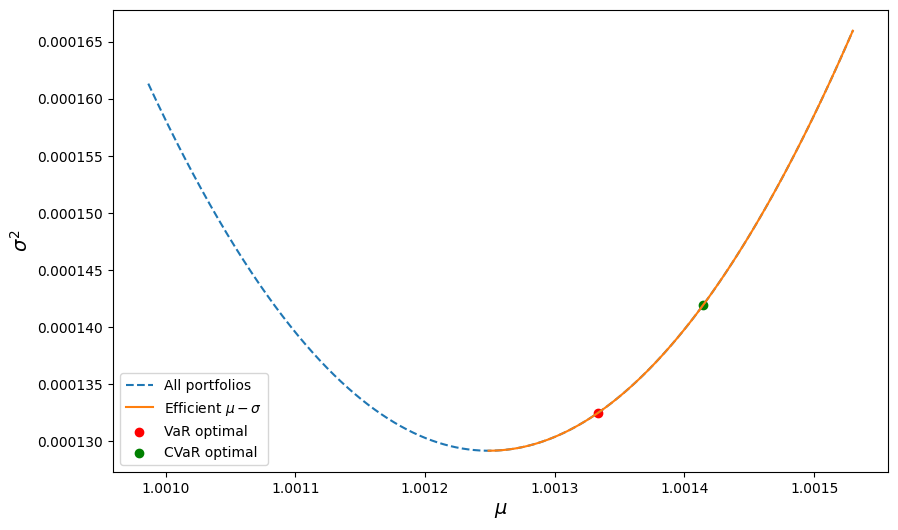

In [16]:
plt.figure(figsize=(10, 6))

plt.plot(portfolios[:, 0], portfolios[:, 1],
         label='All portfolios', linestyle='--'
         )
plt.plot(efficient_portfolios[:, 0], efficient_portfolios[:, 1],
         label='Efficient $\mu-\sigma$'
         )
plt.scatter(var_portfolio["mu"], var_portfolio["variance"],
            label='VaR optimal', color='red'
            )
plt.scatter(cvar_portfolio["mu"], cvar_portfolio["variance"],
            label='CVaR optimal', color='green'
            )

plt.xlabel('$\mu$', fontsize=14)
plt.ylabel('$\sigma^2$', fontsize=14)
plt.legend()

plt.show()

## Расчет эффективной границы по критерию $\mu-\sigma$ предпочтений (свертка критериев, выпуклая оптимизация)

In [17]:
def efficient_return(data, target_return) -> np.ndarray | None:
    n = data.shape[1]
    covariance = data.cov().to_numpy()
    expected_returns = data.mean()

    x = cp.Variable(n)
    variance = cp.quad_form(x, covariance)
    mu = x @ expected_returns

    objective = cp.Minimize(variance)
    constraints = [mu >= target_return, x >= 0, cp.sum(x) == 1]
    prob = cp.Problem(objective, constraints)
    solution = prob.solve(solver=cp.ECOS)
    return prob.status, x.value

In [18]:
min_return = min(expected_returns)
max_return = max(expected_returns)

portfolios = []

for target in np.arange(min_return, max_return, 0.000001):
    status, x = efficient_return(data, target)
    portfolios.append(
        (x @ expected_returns, cp.quad_form(x, covariance).value)
    )
portfolios = np.array(portfolios)

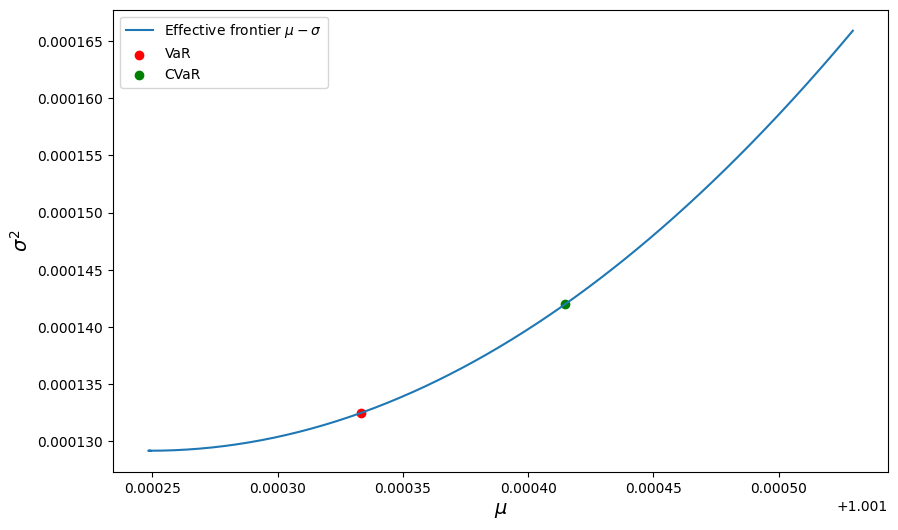

In [19]:
plt.figure(figsize=(10, 6))

plt.plot(portfolios[:, 0], portfolios[:, 1],
         label='Effective frontier $\mu-\sigma$'
         )
plt.scatter(var_portfolio["mu"], var_portfolio["variance"],
            label='VaR', color='red'
            )
plt.scatter(cvar_portfolio["mu"], cvar_portfolio["variance"],
            label='CVaR', color='green'
            )

plt.xlabel('$\mu$', fontsize=14)
plt.ylabel('$\sigma^2$', fontsize=14)
plt.legend()

plt.show()